In [1]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import pandas as pd
import xarray as xr
import cftime
import datetime
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
import seaborn as sns; sns.set(color_codes=True)


from sklearn.metrics.pairwise import haversine_distances

grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


## Load Data
### Obs: BGEP moorings, SWIFT buoys, SODA (APL)
### Bootstrap obs (satellite)
### Wave-ice model simulation

In [2]:
# Read in mooring data for 4 time periods from 3 files
bdir = '/glade/work/lettier/BGEP/'
files = ['BGEP-A_AWAC_2012-2013_converted.nc',
         'BGEP-D_AWAC_2014-2015_converted.nc',
         'BGEP-A_AWAC_2017-2018_converted.nc',]        
bounds = [['2012-08','2012-11'],
          ['2015-08','2015-10'],
          ['2017-10','2017-12'],
          ['2018-07','2018-10']]

bds12 = xr.open_dataset(bdir+files[0]).sel(time=slice(bounds[0][0],bounds[0][1]))
bds15 = xr.open_dataset(bdir+files[1]).sel(time=slice(bounds[1][0],bounds[1][1]))
bds17 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[2][0],bounds[2][1]))
bds18 = xr.open_dataset(bdir+files[2]).sel(time=slice(bounds[3][0],bounds[3][1]))

# pre 2018 model data
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
ice_file = 'cicefsdww3i.cice.h.concat.0068-0084.nc' # monthly ice output
wave_file = 'cicefsdww3i.ww3.sigheight.2000-2016.nc' # daily wave output
mwds = xr.open_dataset(mdir_adj+wave_file)
mwds = mwds.set_coords(['longitude','latitude'])

# 2018 model output
ww18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/ww3.2018.nc').set_coords(['longitude','latitude'])
# wind18 = np.sqrt(ww18.vwnd**2+ww18.uwnd**2)

cice18 = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/cicefsdww3i.cice.h1.2018.nc') # 2018 model output
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
start = pd.Timestamp(ww18.time.values[0])
end = pd.Timestamp(ww18.time.values[-1])
t = np.linspace(start.value, end.value, len(cice18.time))
t = (pd.to_datetime(t)).round('D')
cice18.time.values = np.asarray(t) # adjust time to be year 2018
dist_cice18_6h = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/cice_iceedgedistance_2018.nc') # output from dist formula

# SODA data
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigWaves.mat_converted.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigWaves.mat_converted.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigWaves.mat_converted.nc')
sodaAice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_A_sigIce.mat_converted.nc')
sodaBice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_B_sigIce.mat_converted.nc')
sodaCice = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/SODA_C_sigIce.mat_converted.nc')
sodaA = (sodaA.assign(iceDraftAST=sodaAice.iceDraftAST)).assign(iceDraftLE=sodaAice.iceDraftLE) # add icedraft vars
sodaB = (sodaB.assign(iceDraftAST=sodaBice.iceDraftAST)).assign(iceDraftLE=sodaBice.iceDraftLE)
sodaC = (sodaC.assign(iceDraftAST=sodaCice.iceDraftAST)).assign(iceDraftLE=sodaCice.iceDraftLE) 

# SWIFT data
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

    
# Get observations from NSIDC bootstrap, regridded to match CICE grid
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2018_cicegrid.nc' # name of regridded file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
dist_sat18 = xr.open_dataarray('/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2018.nc') # output from dist formula



### Function to calculate distance to ice edge

In [3]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
    lats = iceconc_input.TLAT.values
    lons = iceconc_input.TLON.values


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

### Interpolate CICE and Sat obs aice to have timesteps in line with ww3 and with SODA

In [4]:
cice18_6h_aice = cice18.aice_d.interp(time=ww18.time.values)
cice18_6h_hi = cice18.hi_d.interp(time=ww18.time.values)

In [5]:
# interpolate distances from the satellite obs to directly match the SODA data
dist_sat18_sodaA = dist_sat18.interp(time=sodaA.time.values)
dist_sat18_sodaB = dist_sat18.interp(time=sodaB.time.values)
dist_sat18_sodaC = dist_sat18.interp(time=sodaC.time.values)
dist_sat18_BGEP = dist_sat18.interp(time=bds18.time.values)

## Find a 2018 wave event

In [24]:
# ww18.sel(time='2018-07')[0].where(cice18_6h.sel)

In [55]:
bds18.peakwaveperiod

<xarray.DataArray 'peakwaveperiod' (time: 2058)>
array([     nan,      nan,      nan, ..., 3.908397,      nan,      nan])
Coordinates:
  * time     (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
Attributes:
    long_name:  peak_wave_period
    units:      s

# Comparison of Bootstrap with 2018 Model in Obs areas

### BGEP Mooring (lat 75, lon -150) (2018-07-01, 2018-09-24)

In [5]:
# lowess = sm.nonparametric.lowess
# x = bds18.time
# z = lowess(bds18.icethickness,bds18.time,frac=1/8)
# plt.plot(z)
# sns.regplot(bds18.time.values,bds18.icethickness.values)
# x = np.arange()

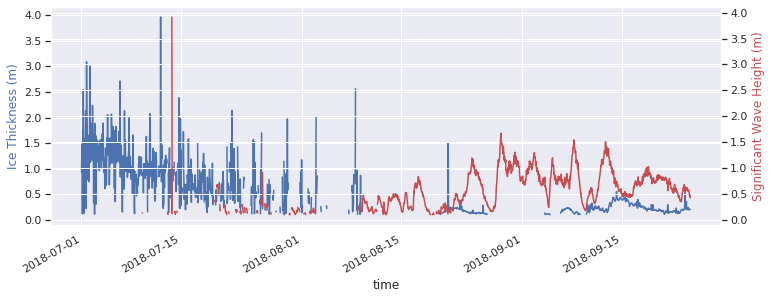

In [107]:
# BGEP
# ice thickness and wave height
fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(ax=ax)
ax2 = ax.twinx()
bds18.sigwaveheight.plot(ax=ax2,color='r')
ax.set_ylabel('Ice Thickness (m)',color='b')
ax2.set_ylabel('Significant Wave Height (m)',color='r')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

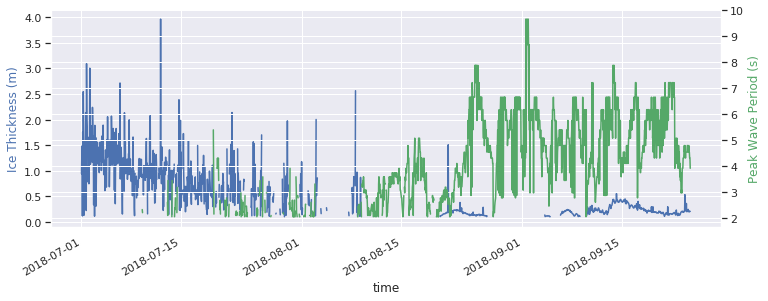

In [108]:
# BGEP
# ice thickness and wave period
fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(ax=ax)
ax2 = ax.twinx()
bds18.peakwaveperiod.plot(ax=ax2,color='g')
ax.set_ylabel('Ice Thickness (m)',color='b')
ax2.set_ylabel('Peak Wave Period (s)',color='g')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

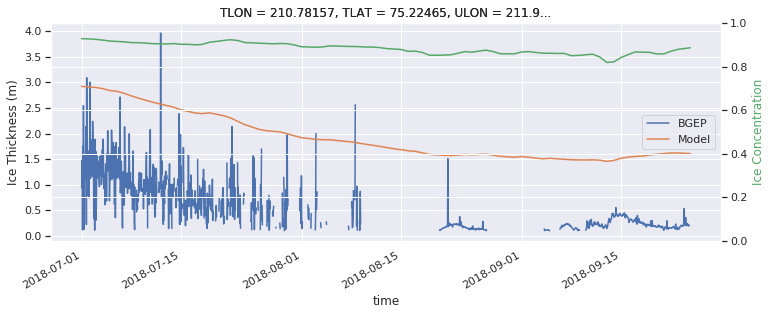

In [123]:
# BGEP and model
# ice thickness
latsel = 350
lonsel = 206
timeslice = slice('2018-07-01','2018-09-24')

fig, ax = plt.subplots(figsize=(12,4))

bds18.icethickness.plot(label='BGEP')
cice18_6h_hi.sel(time=timeslice,nj=latsel,ni=lonsel).plot(label='Model')
ax.set_ylabel('Ice Thickness (m)')
plt.legend(loc=5)

ax2 = ax.twinx()
cice18_6h_aice.sel(time=timeslice,nj=latsel,ni=lonsel).plot(ax=ax2,c='g')
ax2.set_ylabel('Ice Concentration',c='g')
ax2.set_ylim(0.0,1.0)
plt.show(); plt.close()

In [116]:
ww18.hs

<xarray.DataArray 'hs' (time: 1456, nj: 384, ni: 320)>
[178913280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-30T18:00:00
Dimensions without coordinates: nj, ni
Attributes:
    long_name:      significant height of wind and swell waves
    standard_name:  sea_surface_wave_significant_height
    globwave_name:  significant_wave_height
    units:          m
    valid_min:      0
    valid_max:      32000

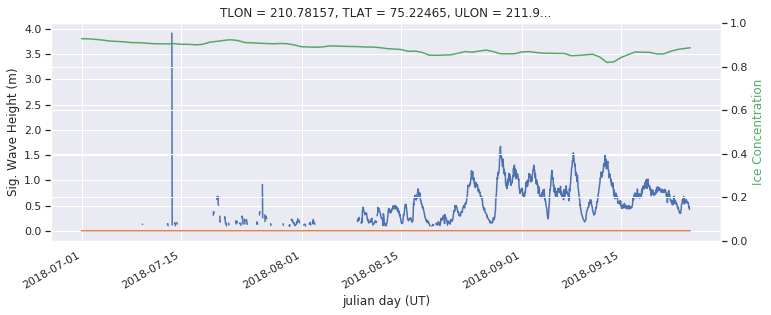

In [117]:
# BGEP and model
# wave height

fig, ax = plt.subplots(figsize=(12,4))

bds18.sigwaveheight.plot()
ww18.hs.sel(time=timeslice,nj=latsel,ni=lonsel).plot()
ax.set_ylabel('Sig. Wave Height (m)')

ax2 = ax.twinx()
cice18_6h_aice.sel(time=timeslice,nj=latsel,ni=lonsel).plot(ax=ax2,c='g')
ax2.set_ylabel('Ice Concentration',c='g')
ax2.set_ylim(0.0,1.0)
plt.show(); plt.close()

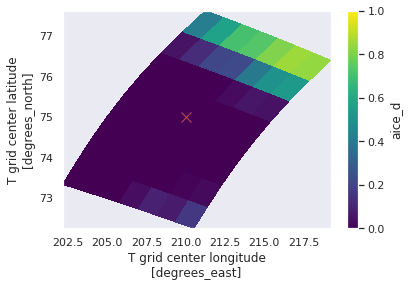

In [4]:
timeslice = slice('2018-09-10','2018-09-24')
latslice = slice(346,354) # 350
lonslice = slice(203,210) # 206

# bootstrap output of ice concentration during a period
boot.sel(time=timeslice,nj=latslice,ni=lonslice).aice_d.mean(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

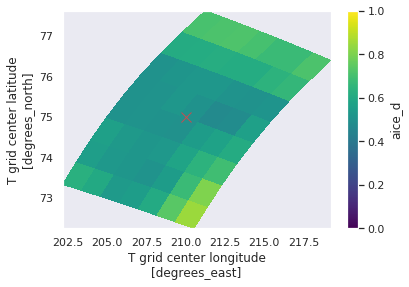

In [5]:
# bootstrap ice during some mooring obs that have ice
timeslice = slice('2018-07-15','2018-07-31')

boot.sel(
    time=timeslice,nj=latslice,ni=lonslice).aice_d.mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

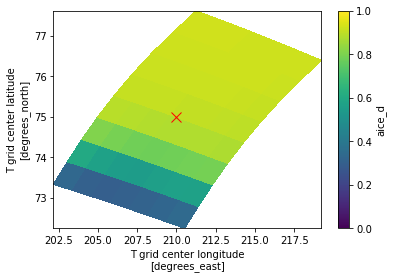

In [78]:
# compare model output of ice cover during same time period
cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0,vmax=1)
plt.plot(210,75,marker='x',c='r',markersize=10)

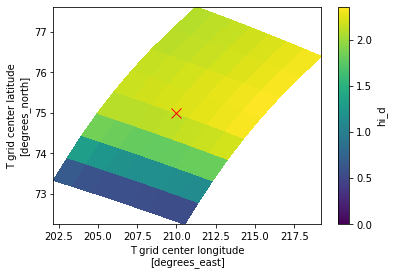

In [80]:
# model output of ice thickness during same time period
cice18.hi_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.pcolormesh(
    'TLON','TLAT',vmin=0)
plt.plot(210,75,marker='x',c='r',markersize=10)

#### Model vs. Bootstrap over BGEP region of interest for each time period

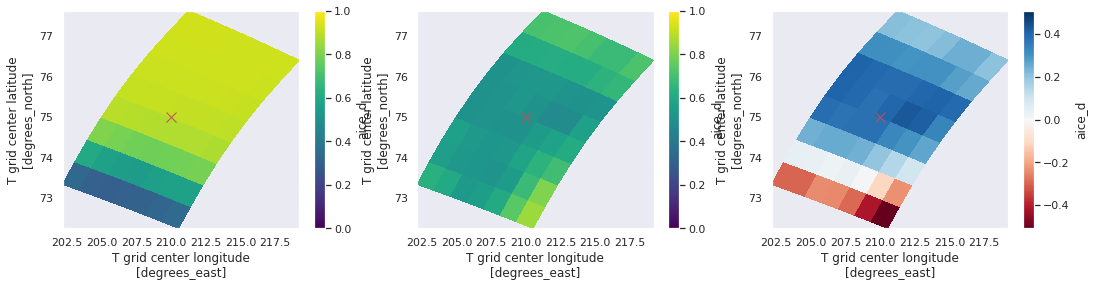

<Figure size 432x288 with 0 Axes>

In [27]:
# Model vs bootstrap: aice
fig = plt.figure(figsize=(18,4))

modelplot = cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time')
bootplot = boot.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time')
diffplot = modelplot - bootplot

# model
ax1 = plt.subplot(1,3,1)
modelplot.plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1,ax=ax1)
plt.plot(210,75,marker='x',c='r',markersize=10)

# boot
ax2 = plt.subplot(1,3,2)
bootplot.plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1,ax=ax2)
plt.plot(210,75,marker='x',c='r',markersize=10)

# diff
ax3 = plt.subplot(1,3,3)
diffplot.plot.pcolormesh('TLON','TLAT',ax=ax3,cmap='RdBu',norm=DivergingNorm(0))
plt.plot(210,75,marker='x',c='r',markersize=10)


plt.show()
plt.tight_layout()

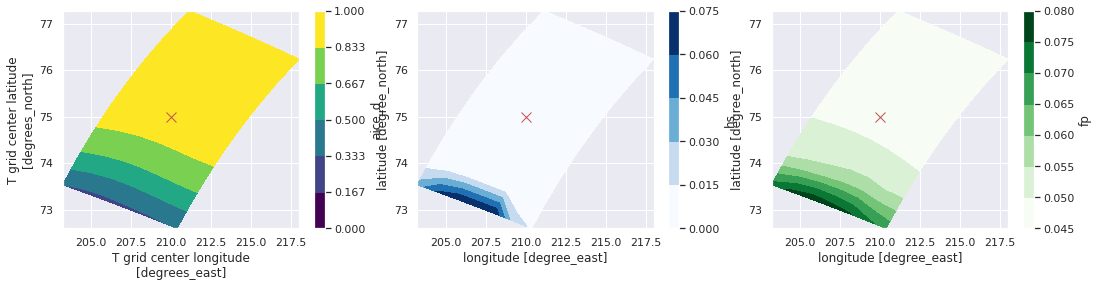

<Figure size 432x288 with 0 Axes>

In [32]:
# Model ice and waves
fig = plt.figure(figsize=(18,4))

# aice
ax1 = plt.subplot(1,3,1)
cice18.aice_d.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'TLON','TLAT',vmin=0,vmax=1,ax=ax1)
plt.plot(210,75,marker='x',c='r',markersize=10)

# boot
ax2 = plt.subplot(1,3,2)
ww18.hs.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'longitude','latitude',cmap='Blues',ax=ax2)
plt.plot(210,75,marker='x',c='r',markersize=10)

# diff
ax3 = plt.subplot(1,3,3)
ww18.fp.sel(
    time=timeslice,nj=latslice,ni=lonslice).mean(dim='time').plot.contourf(
    'longitude','latitude',cmap='Greens',ax=ax3)
plt.plot(210,75,marker='x',c='r',markersize=10)


plt.show()
plt.tight_layout()

## SODA Data

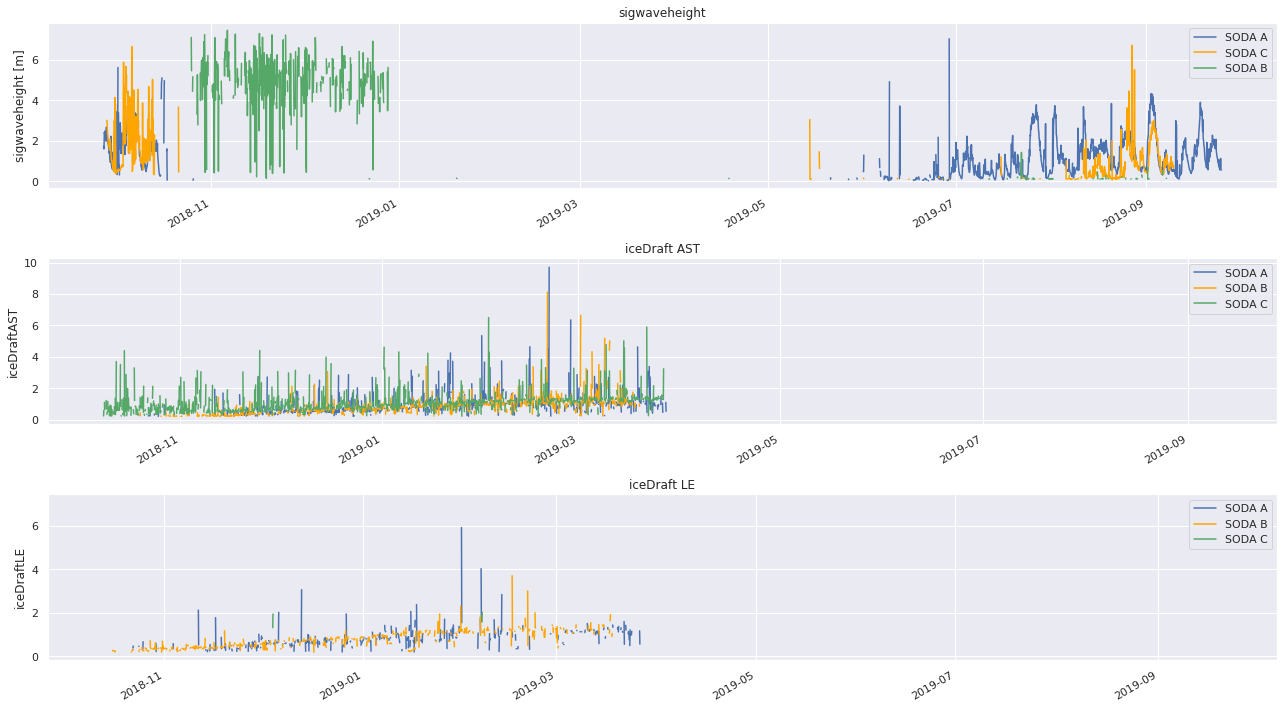

In [16]:
## full period
## SODA wave and ice
fig, ax = plt.subplots(figsize=(18,10))

plt.subplot(311)
sodaA.sigwaveheight.plot(label='SODA A',c='b')
sodaB.sigwaveheight.plot(label='SODA C',c='orange')
sodaC.sigwaveheight.plot(label='SODA B',c='g')
plt.xlabel('')
plt.title('sigwaveheight')
plt.tight_layout()
plt.legend()

plt.subplot(312)
sodaA.iceDraftAST.plot(label='SODA A',c='b')
sodaB.iceDraftAST.plot(label='SODA B',c='orange')
sodaC.iceDraftAST.plot(label='SODA C',c='g')
plt.xlabel('')
plt.title('iceDraft AST')
plt.tight_layout()
plt.legend()

plt.subplot(313)
sodaA.iceDraftLE.plot(label='SODA A',c='b')
sodaB.iceDraftLE.plot(label='SODA B',c='orange')
sodaC.iceDraftLE.plot(label='SODA C',c='g')
plt.xlabel('')
plt.title('iceDraft LE')
plt.tight_layout()
plt.legend()

plt.show()

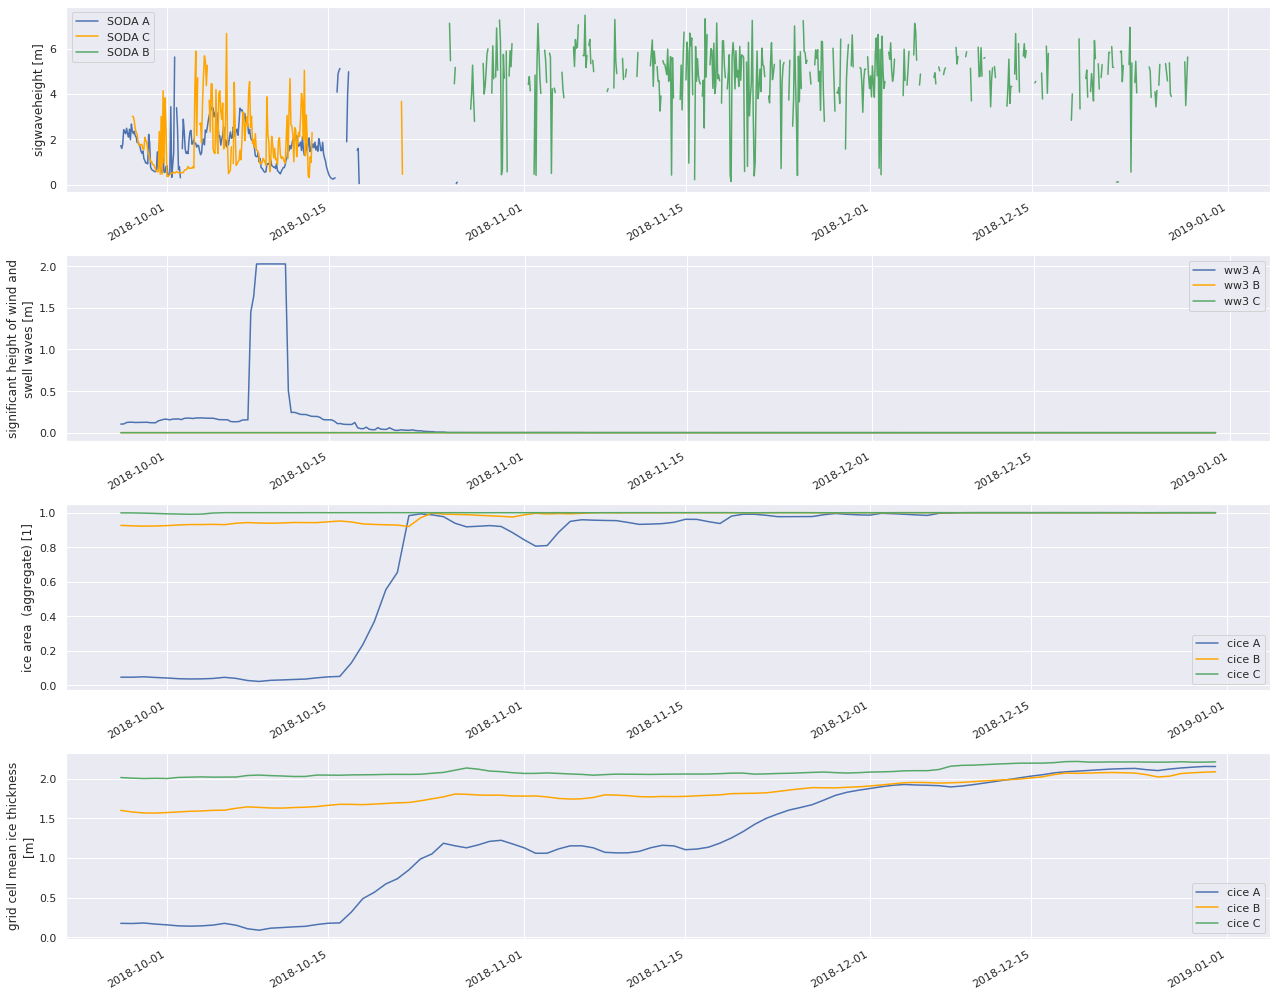

In [11]:
## 2018 period
## SODA vs ww3 and cice output

fig, ax = plt.subplots(figsize=(18,14))
soda18slice = slice('2018-09-27','2018-12-31')

plt.subplot(511)
sodaA.sigwaveheight.sel(time=soda18slice).plot(label='SODA A',c='b')
sodaB.sigwaveheight.sel(time=soda18slice).plot(label='SODA B',c='orange')
sodaC.sigwaveheight.sel(time=soda18slice).plot(label='SODA C',c='g')
plt.tight_layout()
plt.xlabel('')
plt.legend()

plt.subplot(512)
ww18.hs.sel(time=soda18slice,nj=347,ni=210).plot(label='ww3 A',c='b')
ww18.hs.sel(time=soda18slice,nj=351,ni=208).plot(label='ww3 B',c='orange')
ww18.hs.sel(time=soda18slice,nj=356,ni=208).plot(label='ww3 C',c='g')
plt.xlabel('')
plt.tight_layout()
plt.title('')
plt.legend()

plt.subplot(513)
cice18.aice_d.sel(time=soda18slice,nj=347,ni=210).plot(label='cice A',c='b')
cice18.aice_d.sel(time=soda18slice,nj=351,ni=208).plot(label='cice B',c='orange')
cice18.aice_d.sel(time=soda18slice,nj=356,ni=208).plot(label='cice C',c='g')
plt.xlabel('')
plt.title('')
plt.tight_layout()
plt.legend()

plt.subplot(514)
cice18.hi_d.sel(time=soda18slice,nj=347,ni=210).plot(label='cice A',c='b')
cice18.hi_d.sel(time=soda18slice,nj=351,ni=208).plot(label='cice B',c='orange')
cice18.hi_d.sel(time=soda18slice,nj=356,ni=208).plot(label='cice C',c='g')
plt.xlabel('')
plt.title('')
plt.tight_layout()
plt.legend()

plt.show()

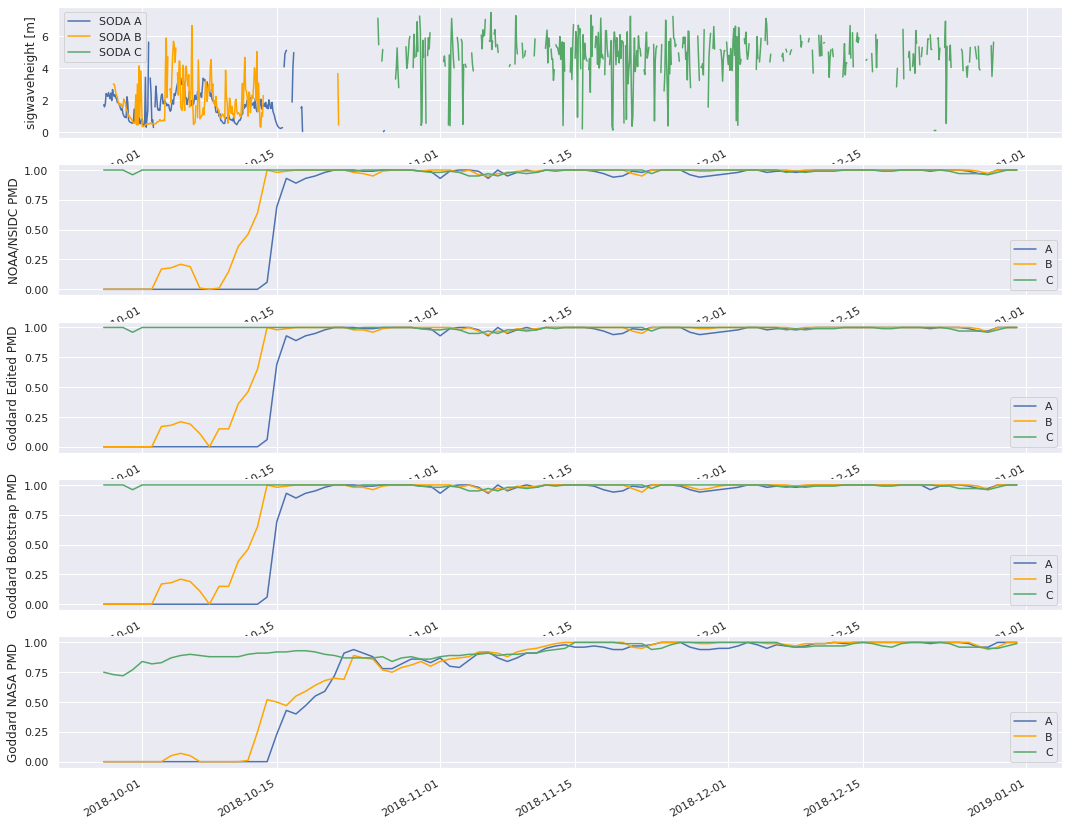

<Figure size 432x288 with 0 Axes>

In [113]:
## 2018 period
## SODA vs sat obs

fig, ax = plt.subplots(figsize=(18,14))

plt.subplot(511)
sodaA.sigwaveheight.sel(time=soda18slice).plot(label='SODA A',c='b')
sodaB.sigwaveheight.sel(time=soda18slice).plot(label='SODA B',c='orange')
sodaC.sigwaveheight.sel(time=soda18slice).plot(label='SODA C',c='g')
plt.xlabel('')
plt.legend()

plt.subplot(512)
boot.aice_d.sel(time=soda18slice,nj=347,ni=210).plot(label='A',c='b')
boot.aice_d.sel(time=soda18slice,nj=351,ni=208).plot(label='B',c='orange')
boot.aice_d.sel(time=soda18slice,nj=356,ni=208).plot(label='C',c='g')
plt.xlabel('')
plt.ylabel('NOAA/NSIDC PMD')
plt.title('')
plt.legend()

plt.subplot(513)
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='A',c='b')
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='B',c='orange')
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='C',c='g')
plt.xlabel('')
plt.ylabel('Goddard Edited PMD')
plt.title('')
plt.legend()

plt.subplot(514)
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='A',c='b')
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='B',c='orange')
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='C',c='g')
plt.xlabel('')
plt.ylabel('Goddard Bootstrap PMD')
plt.title('')
plt.legend()

plt.subplot(515)
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='A',c='b')
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='B',c='orange')
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='C',c='g')
plt.xlabel('')
plt.ylabel('Goddard NASA PMD')
plt.title('')
plt.legend()

plt.show(); plt.tight_layout()

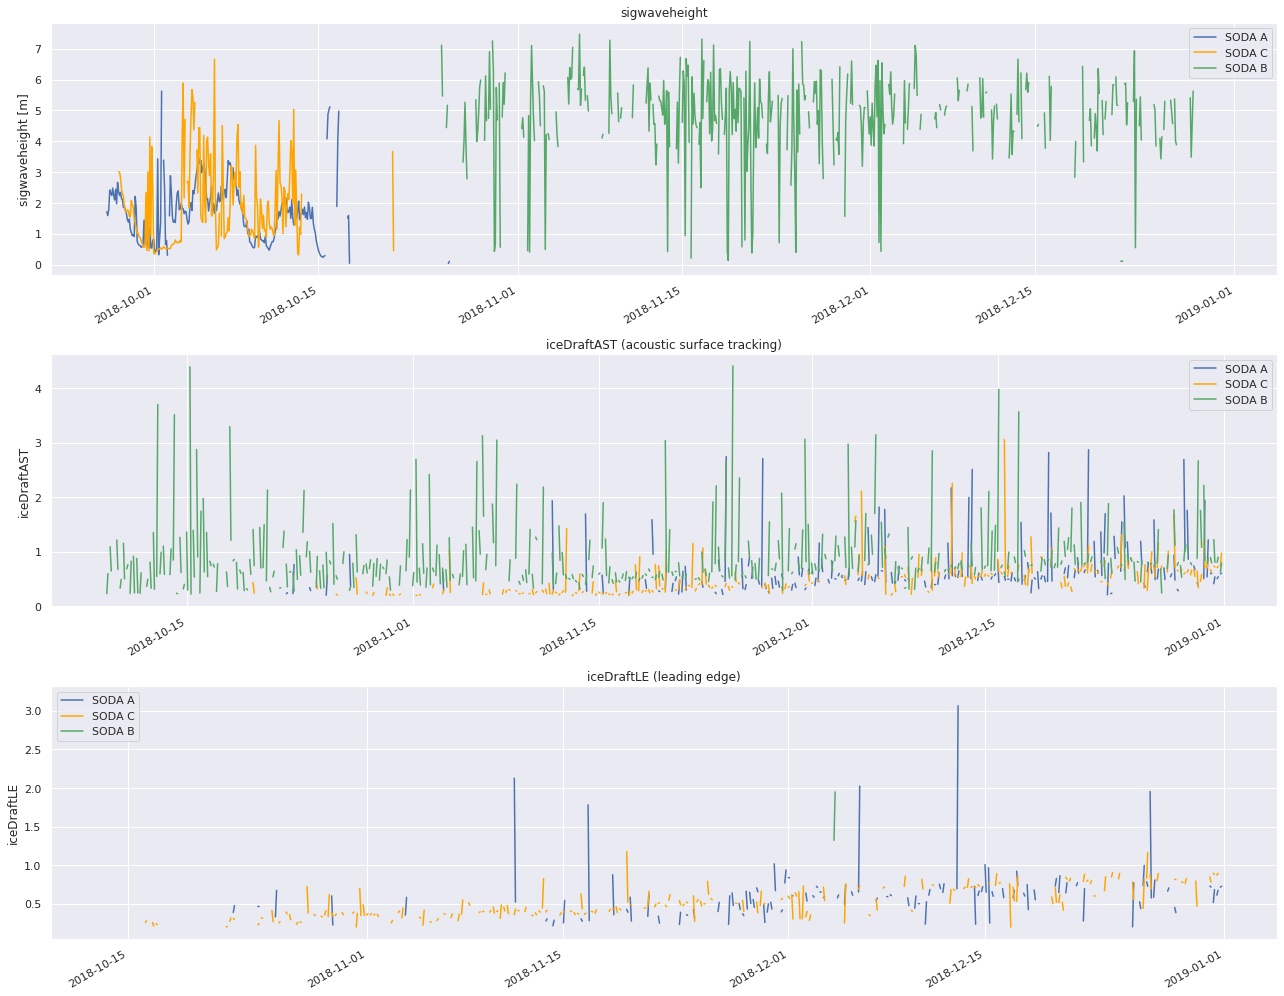

In [12]:
## 2018 period
## SODA waves and ice drafts

fig, ax = plt.subplots(figsize=(18,14))
soda18slice = slice('2018-09-27','2018-12-31')

plt.subplot(311)
sodaA.sigwaveheight.sel(time=soda18slice).plot(label='SODA A',c='b')
sodaB.sigwaveheight.sel(time=soda18slice).plot(label='SODA C',c='orange')
sodaC.sigwaveheight.sel(time=soda18slice).plot(label='SODA B',c='g')
plt.tight_layout()
plt.xlabel('')
plt.title('sigwaveheight')
plt.legend()

plt.subplot(312)
sodaA.iceDraftAST.sel(time=soda18slice).plot(label='SODA A',c='b')
sodaB.iceDraftAST.sel(time=soda18slice).plot(label='SODA C',c='orange')
sodaC.iceDraftAST.sel(time=soda18slice).plot(label='SODA B',c='g')
plt.xlabel('')
plt.tight_layout()
plt.title('iceDraftAST (acoustic surface tracking)')
plt.legend()

plt.subplot(313)
sodaA.iceDraftLE.sel(time=soda18slice).plot(label='SODA A',c='b')
sodaB.iceDraftLE.sel(time=soda18slice).plot(label='SODA C',c='orange')
sodaC.iceDraftLE.sel(time=soda18slice).plot(label='SODA B',c='g')
plt.xlabel('')
plt.tight_layout()
plt.title('iceDraftLE (leading edge)')
plt.legend()

plt.show()

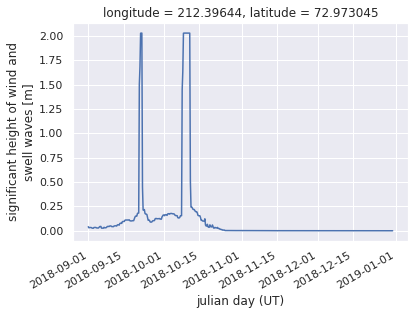

In [19]:
# sodaA.sigwaveheight.plot()
ww18.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3')

## Individual SODA comparisons (and BGEP)

#### Compare SODA, the satellite obs, and CICE in its grid cell

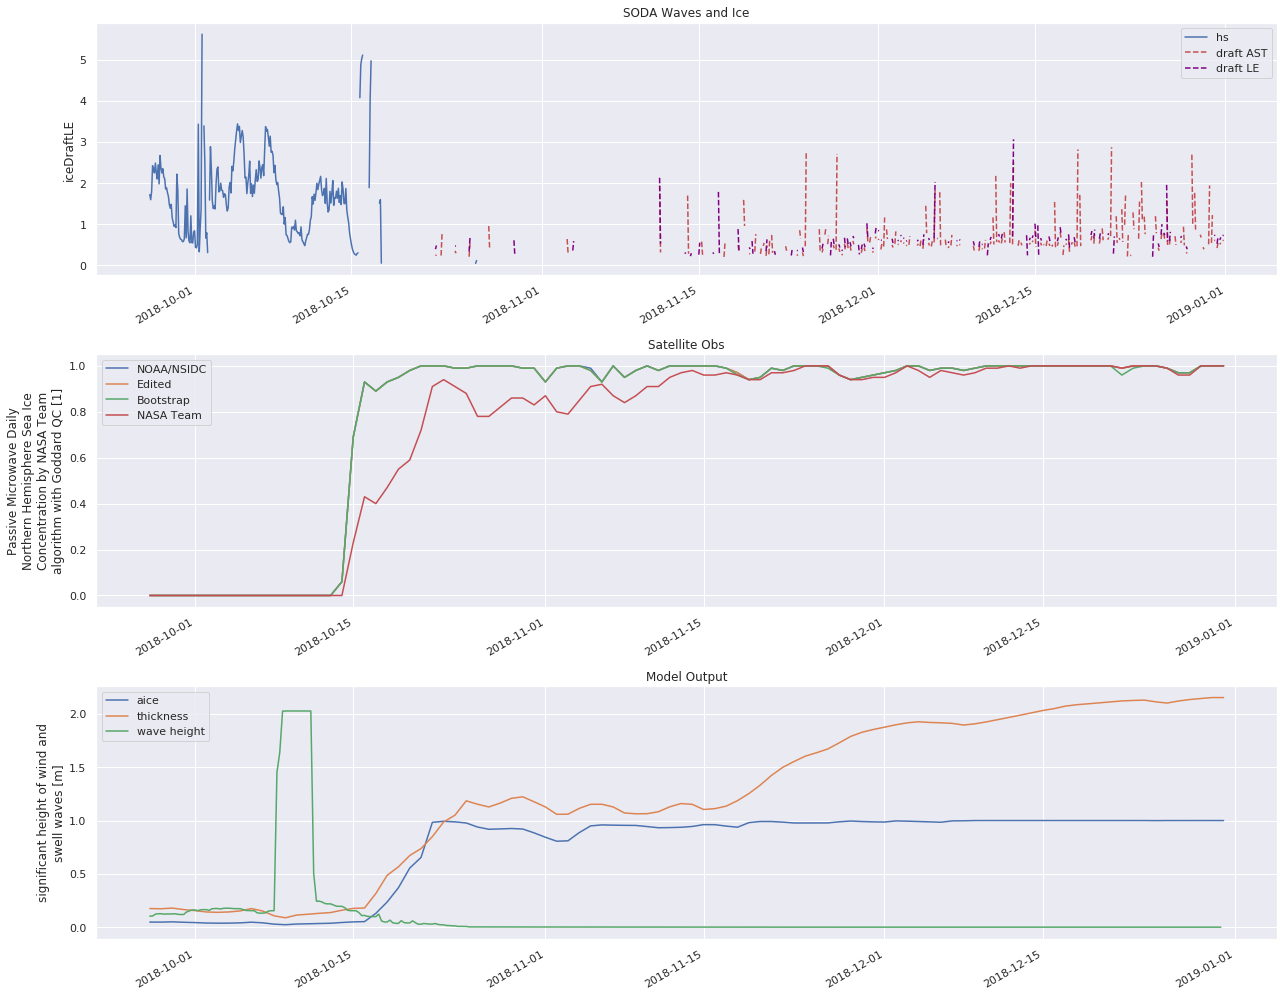

In [18]:
# SODA A
fig = plt.subplots(figsize=(18,14))

# SODA waves and ice
plt.subplot(311)
sodaA.sigwaveheight.sel(time=soda18slice).plot(label='hs',c='b')
sodaA.iceDraftAST.sel(time=soda18slice).plot(label='draft AST',c='r',linestyle='--')
sodaA.iceDraftLE.sel(time=soda18slice).plot(label='draft LE',c='purple',linestyle='--')
plt.xlabel('')
plt.title('SODA Waves and Ice')
plt.legend()
plt.tight_layout()

# all four Sat obs
plt.subplot(312)
boot.aice_d.sel(time=soda18slice,nj=347,ni=210).plot(label='NOAA/NSIDC')
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='Edited')
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='Bootstrap')
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=347,ni=210).plot(label='NASA Team')
plt.xlabel('')
plt.title('Satellite Obs')
plt.legend()
plt.tight_layout()

# Model output (cice and ww3)
plt.subplot(313)
cice18.aice_d.sel(time=soda18slice,nj=347,ni=210).plot(label='aice')
cice18.hi_d.sel(time=soda18slice,nj=347,ni=210).plot(label='thickness')
ww18.hs.sel(time=soda18slice,nj=347,ni=210).plot(label='wave height')
plt.xlabel('')
plt.title('Model Output')
plt.legend()
plt.tight_layout()


plt.show()

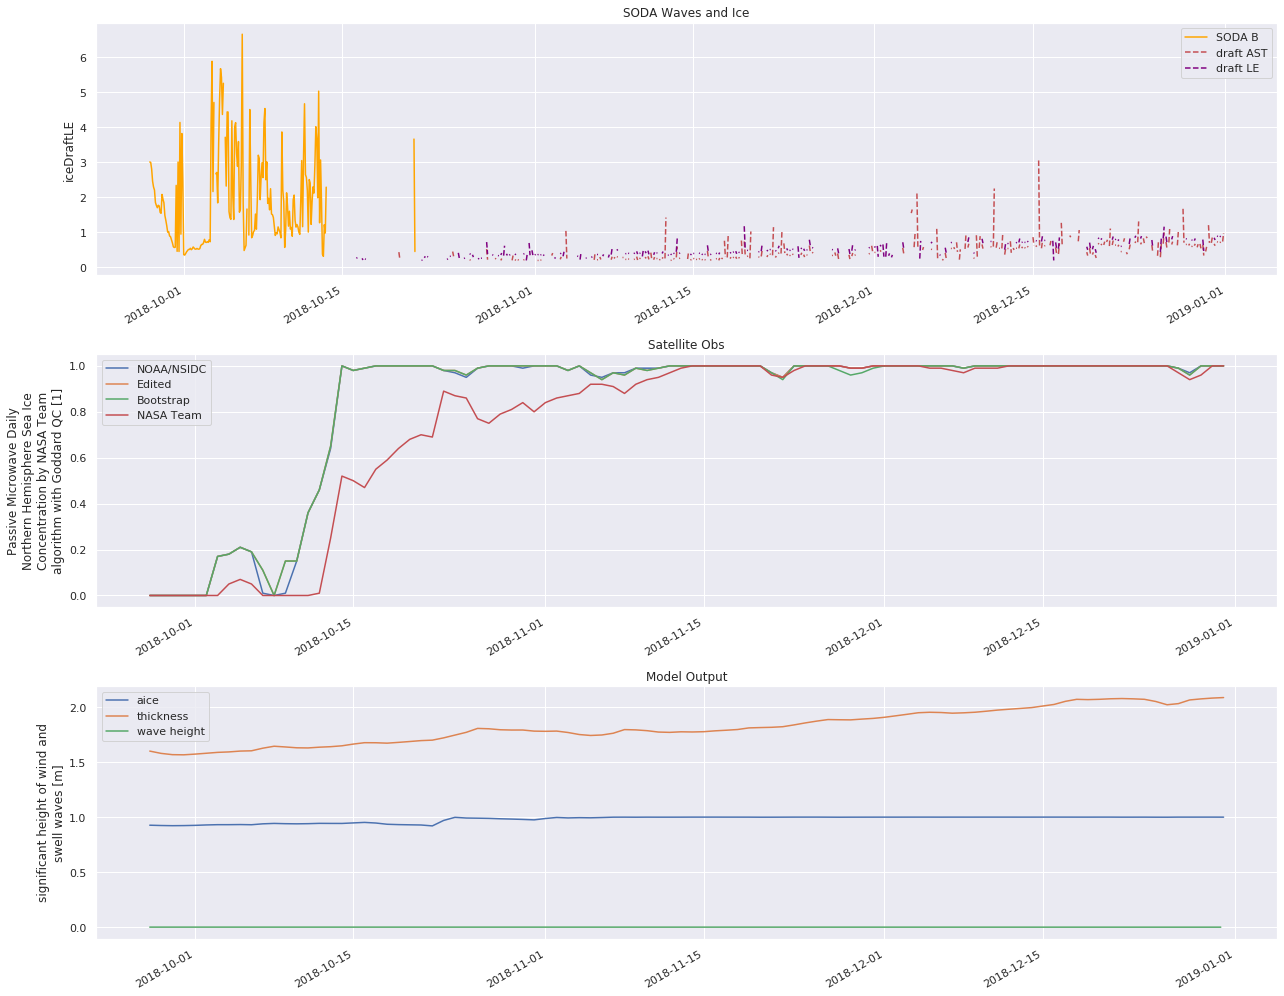

In [19]:
# SODA B
fig = plt.subplots(figsize=(18,14))

# SODA waves and ice
plt.subplot(311)
sodaB.sigwaveheight.sel(time=soda18slice).plot(label='SODA B',c='orange')
sodaB.iceDraftAST.sel(time=soda18slice).plot(label='draft AST',c='r',linestyle='--')
sodaB.iceDraftLE.sel(time=soda18slice).plot(label='draft LE',c='purple',linestyle='--')
plt.xlabel('')
plt.title('SODA Waves and Ice')
plt.legend()
plt.tight_layout()

# all four Sat obs
plt.subplot(312)
boot.aice_d.sel(time=soda18slice,nj=351,ni=208).plot(label='NOAA/NSIDC')
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='Edited')
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='Bootstrap')
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=351,ni=208).plot(label='NASA Team')
plt.xlabel('')
plt.title('Satellite Obs')
plt.legend()
plt.tight_layout()

# Model output (cice and ww3)
plt.subplot(313)
cice18.aice_d.sel(time=soda18slice,nj=351,ni=208).plot(label='aice')
cice18.hi_d.sel(time=soda18slice,nj=351,ni=208).plot(label='thickness')
ww18.hs.sel(time=soda18slice,nj=351,ni=208).plot(label='wave height')
plt.xlabel('')
plt.title('Model Output')
plt.legend()
plt.tight_layout()


plt.show()

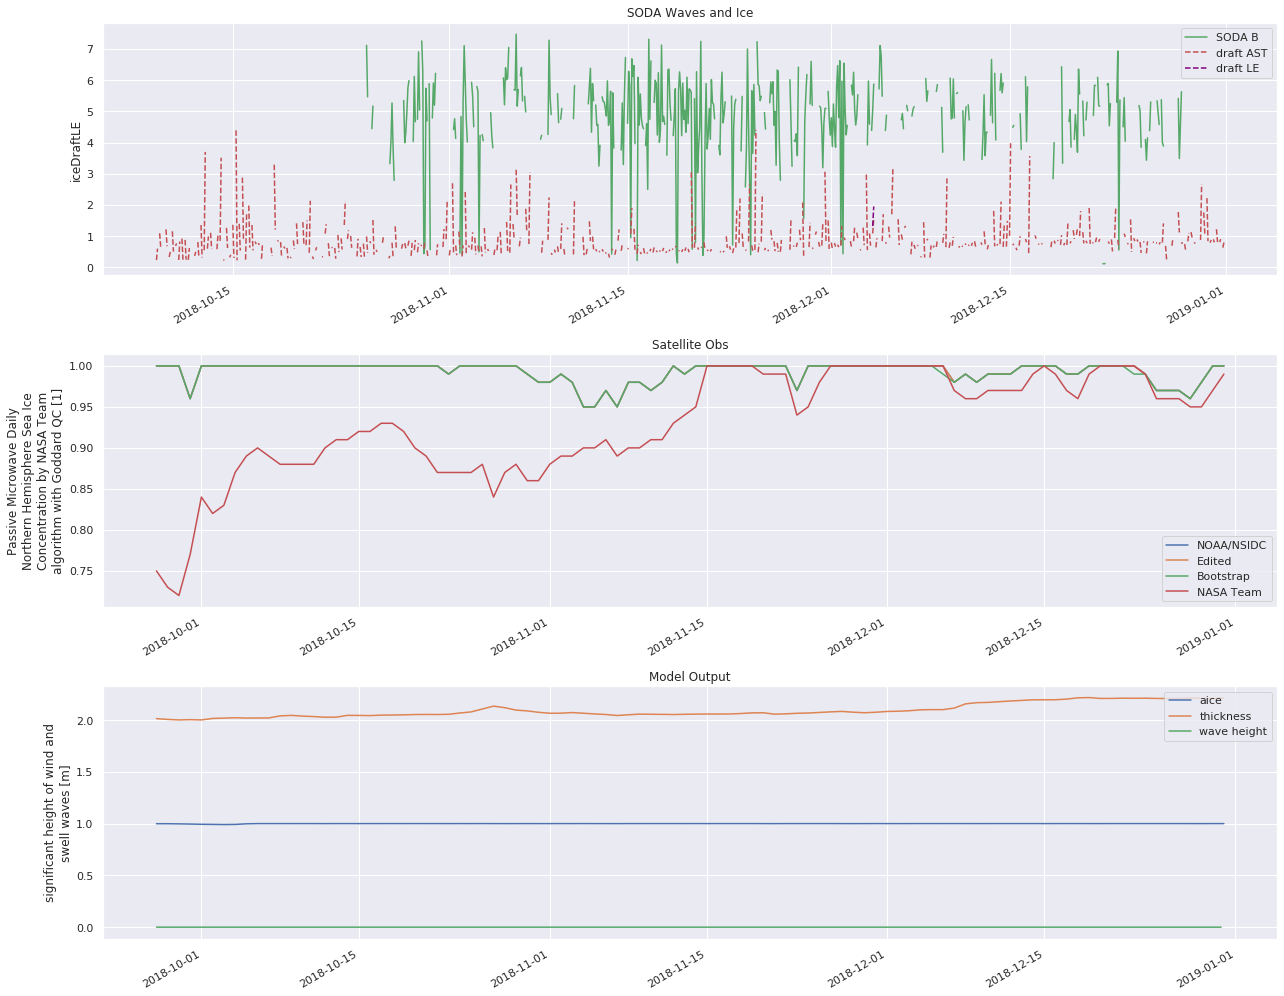

In [20]:
# SODA C
fig = plt.subplots(figsize=(18,14))

# SODA waves and ice
plt.subplot(311)
sodaC.sigwaveheight.sel(time=soda18slice).plot(label='SODA B',c='g')
sodaC.iceDraftAST.sel(time=soda18slice).plot(label='draft AST',c='r',linestyle='--')
sodaC.iceDraftLE.sel(time=soda18slice).plot(label='draft LE',c='purple',linestyle='--')
plt.xlabel('')
plt.title('SODA Waves and Ice')
plt.legend()
plt.tight_layout()

# all four Sat obs
plt.subplot(312)
boot.aice_d.sel(time=soda18slice,nj=356,ni=208).plot(label='NOAA/NSIDC')
boot.goddard_merged_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='Edited')
boot.goddard_bt_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='Bootstrap')
boot.goddard_nt_seaice_conc.sel(time=soda18slice,nj=356,ni=208).plot(label='NASA Team')
plt.xlabel('')
plt.title('Satellite Obs')
plt.legend()
plt.tight_layout()

# Model output (cice and ww3)
plt.subplot(313)
cice18.aice_d.sel(time=soda18slice,nj=356,ni=208).plot(label='aice')
cice18.hi_d.sel(time=soda18slice,nj=356,ni=208).plot(label='thickness')
ww18.hs.sel(time=soda18slice,nj=356,ni=208).plot(label='wave height')
plt.xlabel('')
plt.title('Model Output')
plt.legend()
plt.tight_layout()


plt.show()

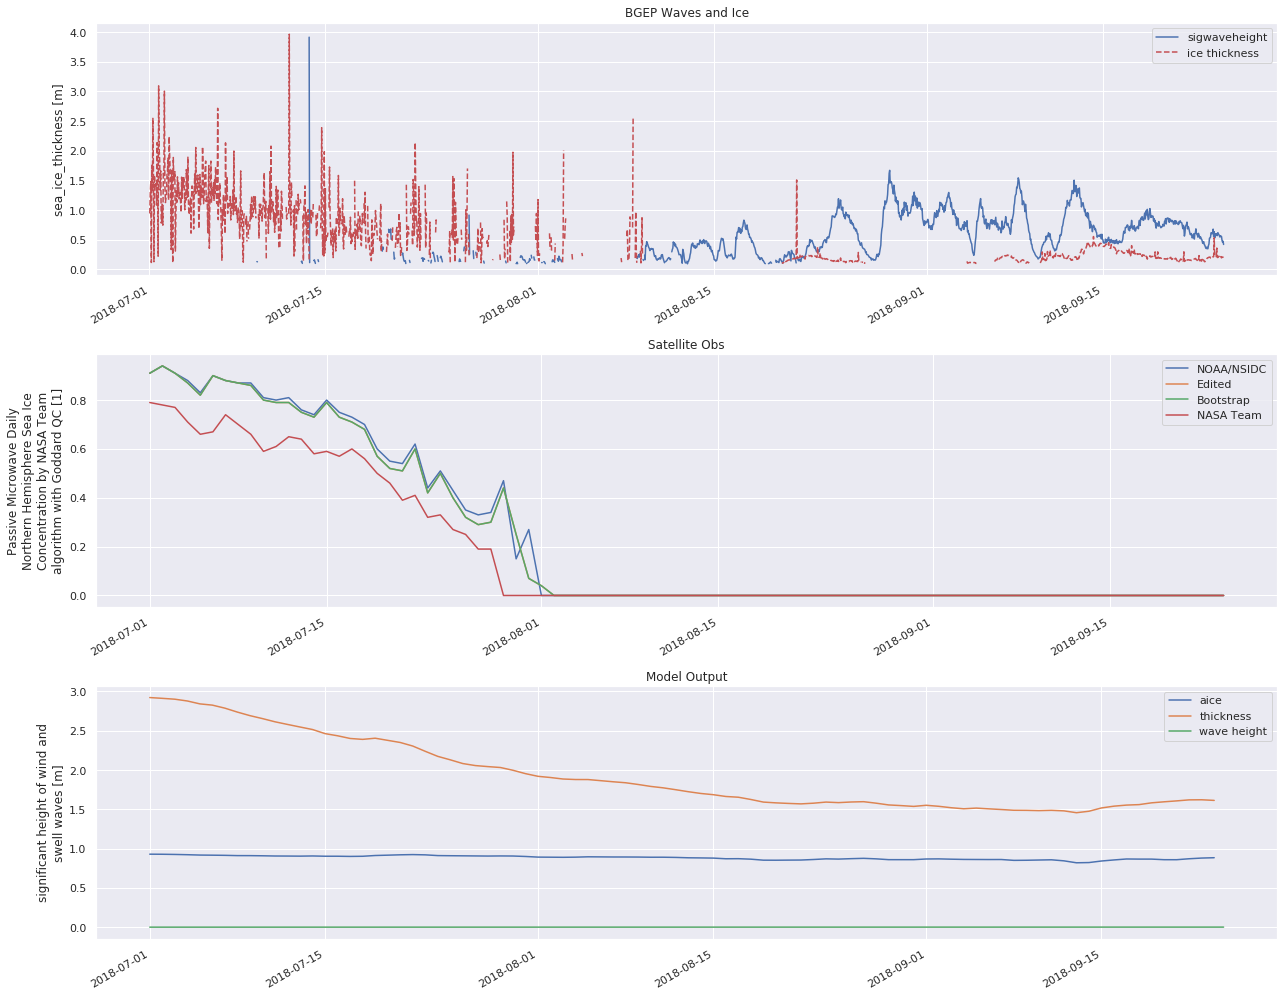

In [22]:
# BGEP 2018
fig = plt.subplots(figsize=(18,14))
bds18slice = slice('2018-07-01','2018-09-24')

# BGEP waves and ice
plt.subplot(311)
bds18.sigwaveheight.sel(time=bds18slice).plot(label='sigwaveheight',c='b')
bds18.icethickness.sel(time=bds18slice).plot(label='ice thickness',c='r',linestyle='--')
plt.xlabel('')
plt.title('BGEP Waves and Ice')
plt.legend()
plt.tight_layout()

# all four Sat obs
plt.subplot(312)
boot.aice_d.sel(time=bds18slice,nj=350,ni=206).plot(label='NOAA/NSIDC')
boot.goddard_merged_seaice_conc.sel(time=bds18slice,nj=350,ni=206).plot(label='Edited')
boot.goddard_bt_seaice_conc.sel(time=bds18slice,nj=350,ni=206).plot(label='Bootstrap')
boot.goddard_nt_seaice_conc.sel(time=bds18slice,nj=350,ni=206).plot(label='NASA Team')
plt.xlabel('')
plt.title('Satellite Obs')
plt.legend()
plt.tight_layout()

# Model output (cice and ww3)
plt.subplot(313)
cice18.aice_d.sel(time=bds18slice,nj=350,ni=206).plot(label='aice')
cice18.hi_d.sel(time=bds18slice,nj=350,ni=206).plot(label='thickness')
ww18.hs.sel(time=bds18slice,nj=350,ni=206).plot(label='wave height')
plt.xlabel('')
plt.title('Model Output')
plt.legend()
plt.tight_layout()

plt.show()

In [14]:
bds18

<xarray.Dataset>
Dimensions:         (freq: 42, time: 2058)
Coordinates:
  * time            (time) datetime64[ns] 2018-07-01T00:31:01.000004 ... 2018-09-24T17:31:00.999998
  * freq            (freq) float64 0.009766 0.02148 0.0332 ... 0.4785 0.4902
Data variables:
    lat             (time) int64 75 75 75 75 75 75 75 ... 75 75 75 75 75 75 75
    lon             (time) int64 -150 -150 -150 -150 ... -150 -150 -150 -150
    icethickness    (time) float64 ...
    sigwaveheight   (time) float64 ...
    peakwaveperiod  (time) float64 ...
    peakwavedirT    (time) float64 ...
    energy          (time, freq) float64 ...
    a1              (time, freq) float64 ...
    b1              (time, freq) float64 ...
    a2              (time, freq) float64 ...
    b2              (time, freq) float64 ...
    check           (time, freq) float64 ...
Attributes:
    description:   AWAC
    processed by:  Jim Thomson, APL

### Some specific analysis on SODA A

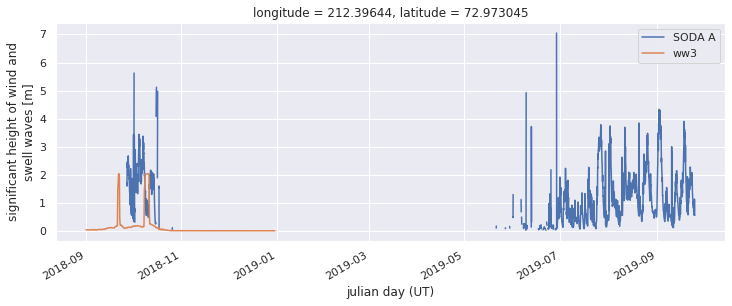

In [181]:
fig, ax = plt.subplots(figsize=(12,4))
sodaA.sigwaveheight.plot(label='SODA A',ax=ax)
ww18.hs.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3',ax=ax)
plt.legend()

# ax2 = ax.twinx()
# cice18.aice_d.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(ax=ax2,color='r')

# ax.set_ylabel('Significant Wave Height (m)')
# ax2.set_ylabel('Ice Concentration',color='r')
# ax.set_ylim(0.0,6.0)
# ax2.set_ylim(0.0,6.0)
plt.show(); plt.close()

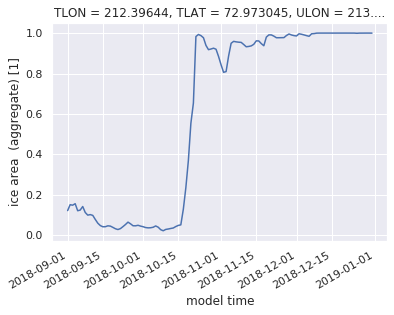

In [184]:
cice18.aice_d.sel(time=slice('2018-09','2018-12'),nj=347,ni=210).plot(label='ww3')

In [ ]:
sodaA.sigwaveheight.sel(time=sodaAtime).plot()
ww18.hs.sel(time=sodaAtime,nj=347,ni=210).plot()

In [158]:
sodaA

<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 4362)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
  * time                (time) datetime64[ns] 2018-09-27 ... 2019-09-25T10:00:00
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 ...
    wavespectra_a1      (time, freq_wavespectra) float64 ...
    wavespectra_b1      (time, freq_wavespectra) float64 ...
    wavespectra_a2      (time, freq_wavespectra) float64 ...
    wavespectra_b2      (time, freq_wavespectra) float64 ...
    wavespectra_check   (time, freq_wavespectra) float64 ...
    lat                 (time) float64 73.0 73.0 73.0 73.0 ... 73.0 73.0 73.0
    lon                 (time) float64 -148.3 -148.3 -148.3 ... -148.3 -148.3
    sigwaveheight       (time) float64 ...
    peakwaveperiod      (time) float64 ...
    peakwavedirT        (time) float64 ...
Attributes:
    description:        sigWaves
    data:               SODA cruise, Sam Brenner, APL
    netcdf_created_by:  Lettie Roach, 2020, UW

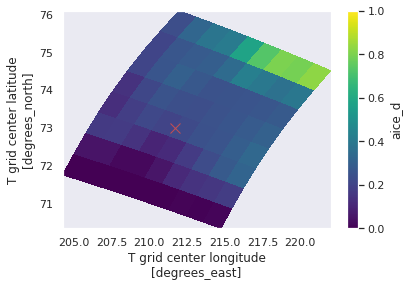

In [164]:
sodaAtime = slice('2018-09-27','2018-10-20')
sodalatslice = slice(344,352)
sodalonslice = slice(206,215)
# lat = 73, lon = 211.7
# cice nj = 347, ni = 211

# bootstrap output of ice concentration during a period
boot.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).aice_d.mean(
    dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

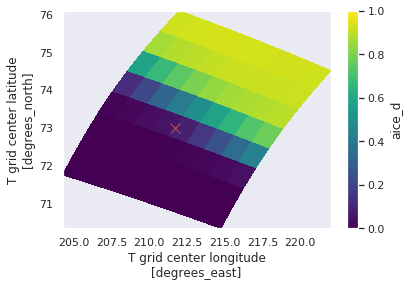

In [156]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

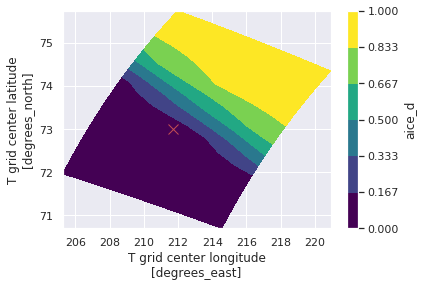

In [162]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(dim='time').plot.contourf('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

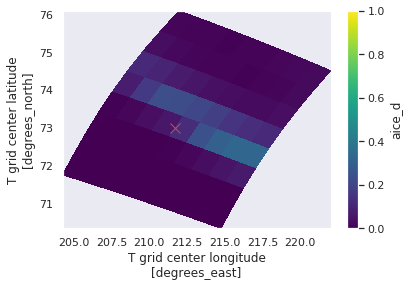

In [183]:
# model output of ice concentration during period
cice18.aice_d.sel(time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(dim='time').plot.pcolormesh('TLON','TLAT',vmin=0,vmax=1)
plt.plot(211.7,73,marker='x',c='r',markersize=10)

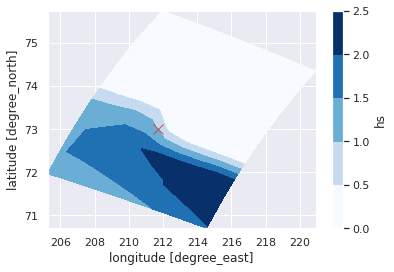

In [166]:
# model output of wave height during period
ww18.hs.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(
    dim='time').plot.contourf('longitude','latitude',cmap='Blues')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

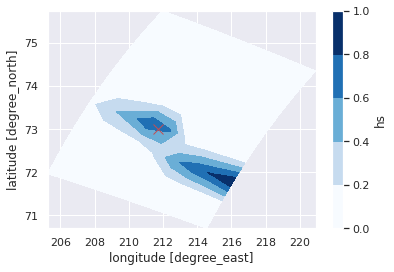

In [170]:
# model output of wave height during period
ww18.hs.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(
    dim='time').plot.contourf('longitude','latitude',cmap='Blues')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

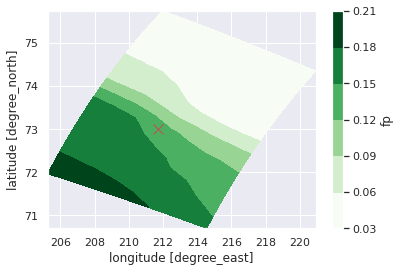

In [173]:
# model output of wave period during period
ww18.fp.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).mean(
    dim='time').plot.contourf('longitude','latitude',cmap='Greens')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

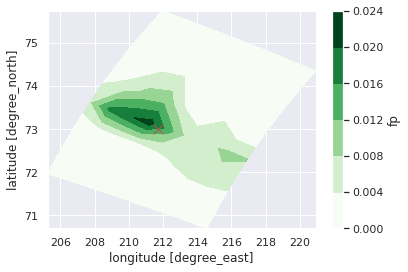

In [172]:
# model output of wave period during period
ww18.fp.sel(
    time=sodaAtime,nj=sodalatslice,ni=sodalonslice).std(
    dim='time').plot.contourf('longitude','latitude',cmap='Greens')
plt.plot(211.7,73,marker='x',c='r',markersize=10)

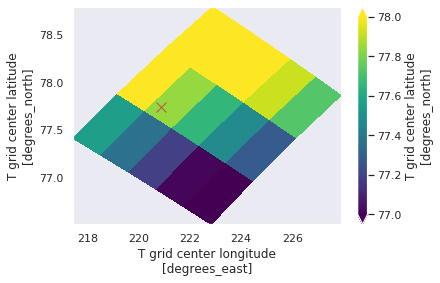

In [36]:
# tool for locating model area

# # SODA A
# latslice = slice(346,348) # 350
# lonslice = slice(210,212) # 206

# # SODA B
# latslice = slice(350,353) # 350
# lonslice = slice(207,210) # 206

# cice18.TLAT.sel(
#     nj=latslice,ni=lonslice).plot.pcolormesh(
#     'TLON','TLAT',vmin=75,vmax=76)
# plt.plot(214.36,75.46,marker='x',c='r',markersize=10)

# SODA C
latslice = slice(355,358) # 350
lonslice = slice(207,212) # 206

cice18.TLAT.sel(
    nj=latslice,ni=lonslice).plot.pcolormesh(
    'TLON','TLAT',vmin=77,vmax=78)
plt.plot(220.86,77.74,marker='x',c='r',markersize=10)

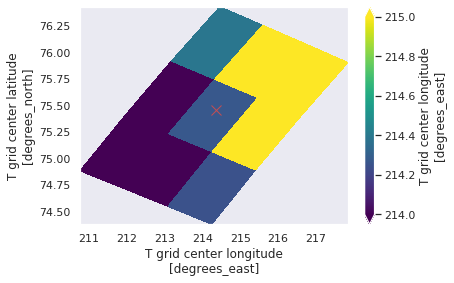

In [27]:
# tool for locating model area

latslice = slice(346,348) # 350
lonslice = slice(210,212) # 206
# cice18.TLAT.plot(vmin=72,vmax=74)
# cice18.TLAT.sel(nj=latslice,ni=lonslice).plot(vmin=72,vmax=74)
# model output of ice thickness during same time period

# SODA B
latslice = slice(350,353) # 350
lonslice = slice(207,210) # 206

cice18.TLON.sel(
    nj=latslice,ni=lonslice).plot.pcolormesh(
    'TLON','TLAT',vmin=214,vmax=215)
plt.plot(214.36,75.46,marker='x',c='r',markersize=10)

In [35]:
print(cice18.TLON.sel(nj=351,ni=208).values,
      cice18.TLAT.sel(nj=351,ni=208).values) # SODA B

print(cice18.TLON.sel(nj=356,ni=208).values,
      cice18.TLAT.sel(nj=356,ni=208).values) # SODA C

214.273 75.405136
221.64684 77.8405


## Model vs. Bootstrap for each month

In [4]:
# calculate monthly means for 2018; model and bootstrap
timeslice = slice('2018-01-01','2018-12-31')
latslice = slice(300,384)
left = cice18.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').mean(dim='time')
right = boot.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').mean(dim='time')
leftsd = cice18.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').std(dim='time')
rightsd = boot.aice_d.sel(time=timeslice,nj=latslice).groupby('time.month').std(dim='time')

diff = left - right

# hack to fix coordinates when taking difference
diff.ULON[:] = left.TLON
diff.ULAT[:] = left.TLAT

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


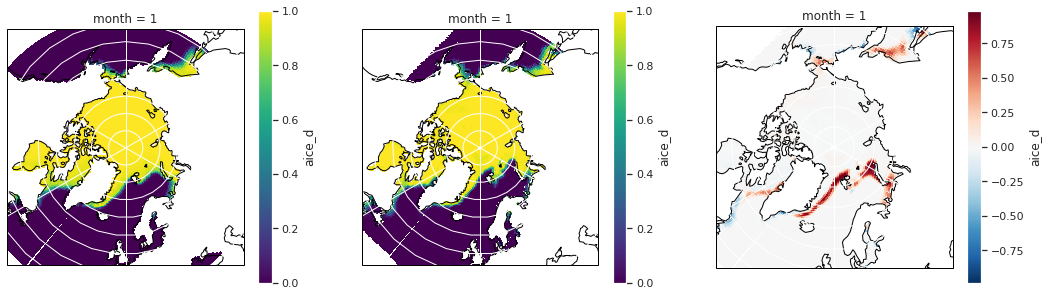

<Figure size 432x288 with 0 Axes>

In [49]:
# January
fig = plt.figure(figsize=(18,5))
monthsel = 1

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.gridlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.gridlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

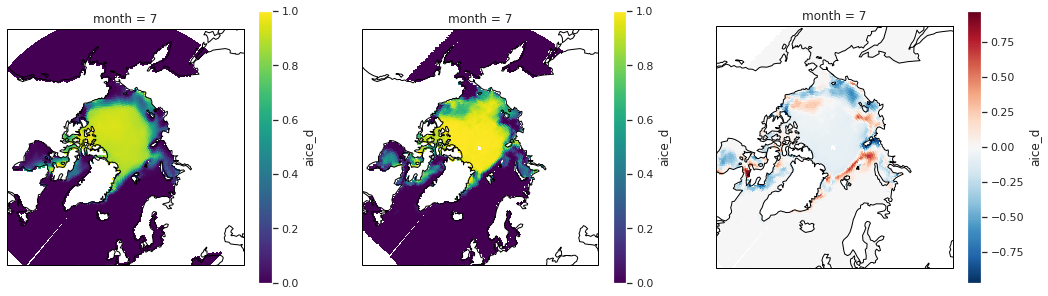

<Figure size 432x288 with 0 Axes>

In [32]:
# July
fig = plt.figure(figsize=(18,5))
monthsel = 7

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

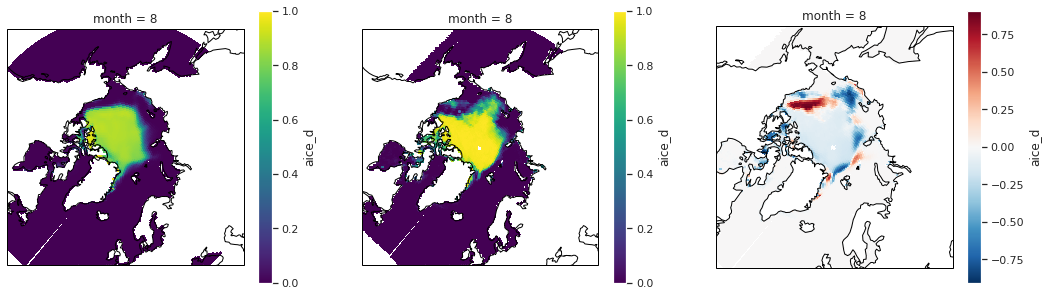

<Figure size 432x288 with 0 Axes>

In [45]:
# Aug
fig = plt.figure(figsize=(18,5))
monthsel = 8

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

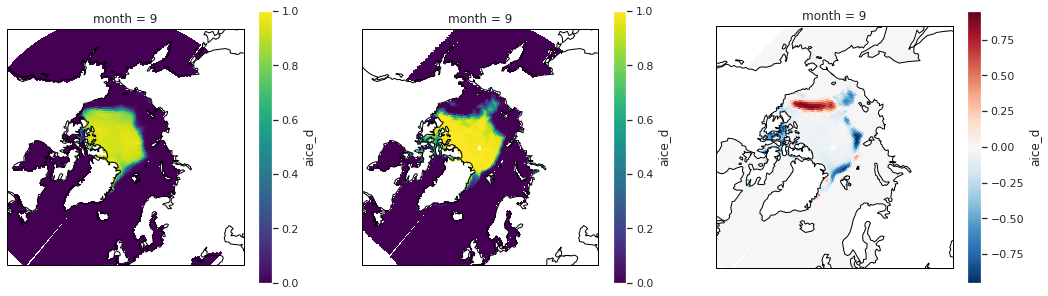

<Figure size 432x288 with 0 Axes>

In [35]:
# Sep
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

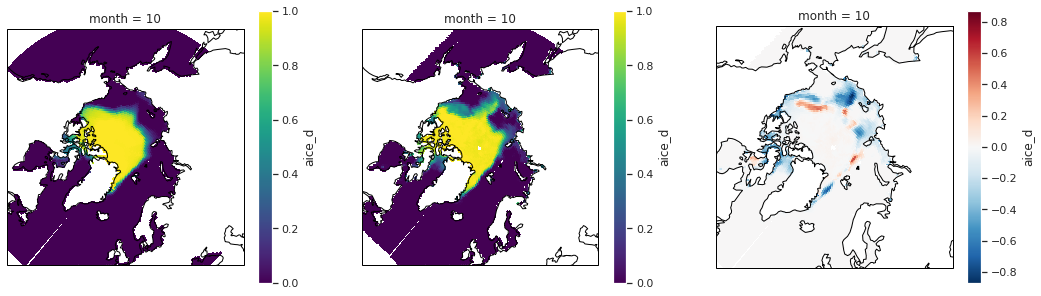

<Figure size 432x288 with 0 Axes>

In [35]:
# Oct
fig = plt.figure(figsize=(18,5))
monthsel = 10

# model
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# boot
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax2, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff.sel(month=monthsel).plot.pcolormesh('ULON','ULAT',ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

### Run distance calculation for one of these months

In [5]:
dist_model = icedistance(left.sel(month=9))
dist_model = xr.DataArray(dist_model,coords=left.sel(month=9).coords)

dist_boot = icedistance(right.sel(month=9))
dist_boot = xr.DataArray(dist_boot,coords=left.sel(month=9).coords)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


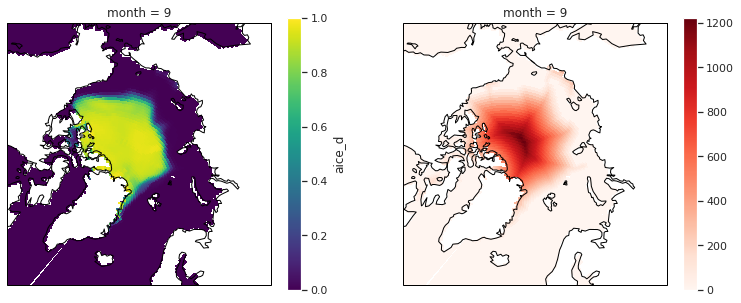

<Figure size 432x288 with 0 Axes>

In [14]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

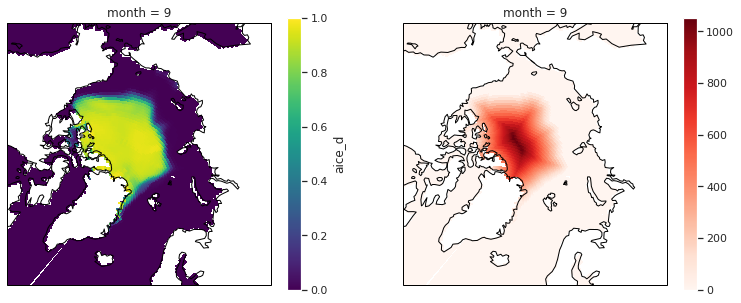

<Figure size 432x288 with 0 Axes>

In [8]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

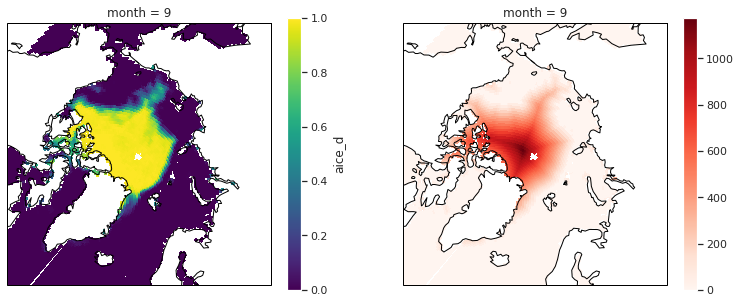

<Figure size 432x288 with 0 Axes>

In [48]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
right.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_boot.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

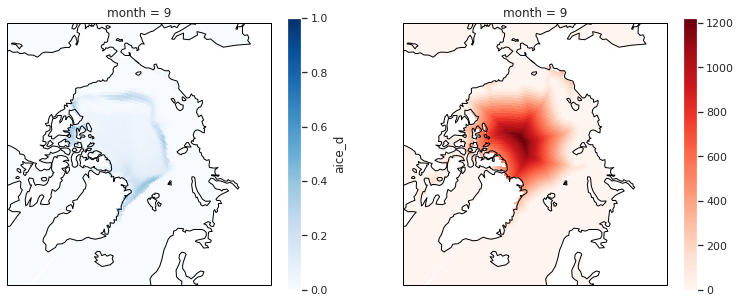

<Figure size 432x288 with 0 Axes>

In [16]:
# Sep
fig = plt.figure(figsize=(13,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
leftsd.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Blues')

# model dist
ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

plt.show()
plt.tight_layout()

### Compare ice, waves, distance

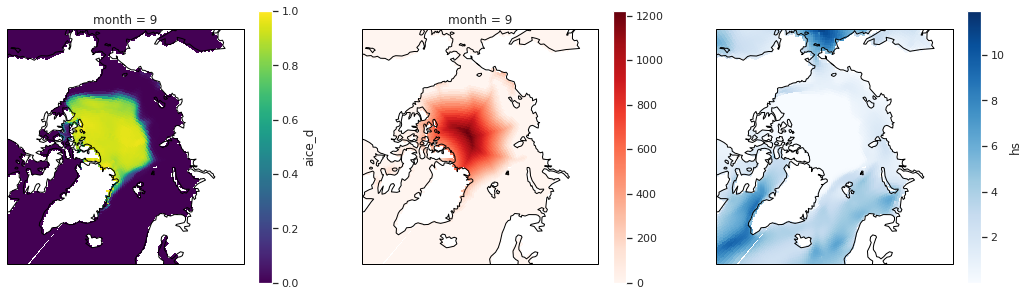

<Figure size 432x288 with 0 Axes>

In [59]:
# Sep: wave mean hs
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).mean(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

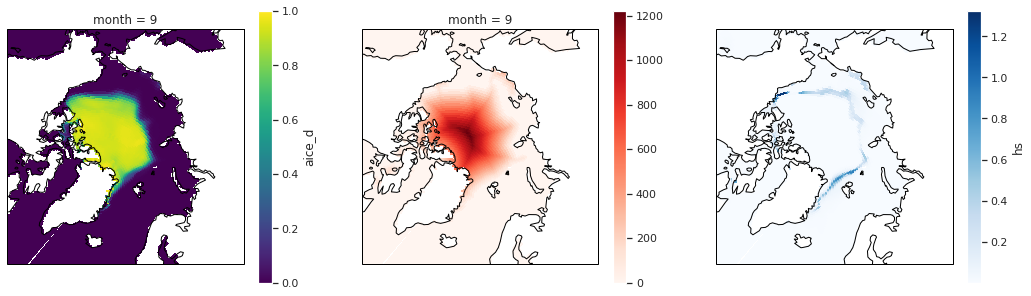

<Figure size 432x288 with 0 Axes>

In [12]:
# Sep: wave stdev
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

In [ ]:
# Sep: wave stdev
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
leftsd.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.hs.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Blues')


plt.show()
plt.tight_layout()

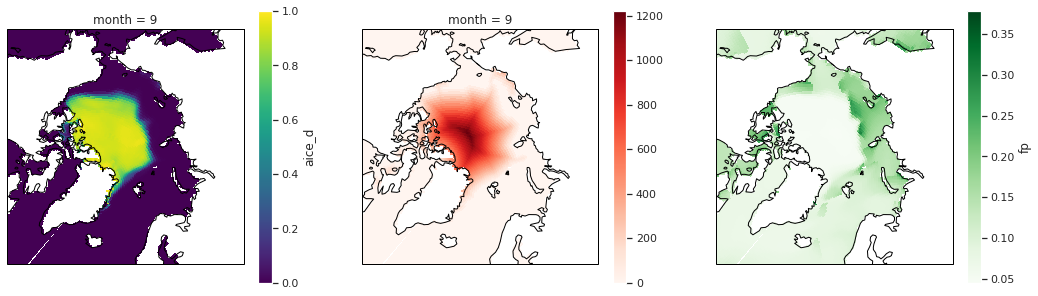

<Figure size 432x288 with 0 Axes>

In [61]:
# Sep: mean fp
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.fp.sel(time=slice('2018-09-01','2018-09-30')).mean(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Greens')


plt.show()
plt.tight_layout()

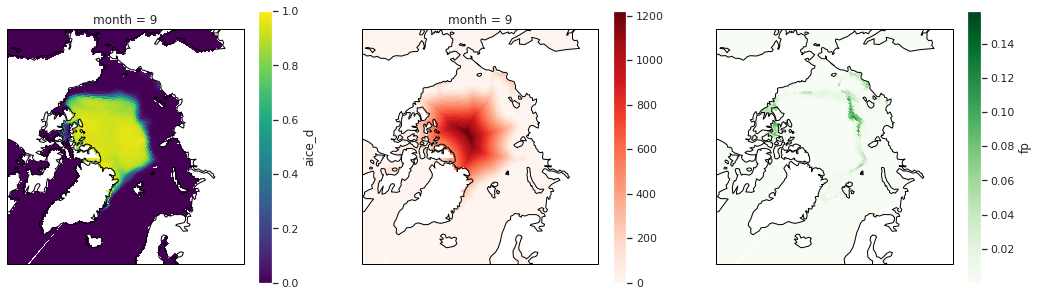

<Figure size 432x288 with 0 Axes>

In [63]:
# Sep: stdev fp
fig = plt.figure(figsize=(18,5))
monthsel = 9

# model aice
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
left.sel(month=monthsel).plot.pcolormesh('TLON','TLAT',ax=ax1, transform=ccrs.PlateCarree(),vmin=0,vmax=1)

# model dist
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
ax2.coastlines()
ax2.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_model.plot.pcolormesh('TLON','TLAT',ax=ax2,transform=ccrs.PlateCarree(),cmap='Reds')

# model hs
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
ww18.fp.sel(time=slice('2018-09-01','2018-09-30')).std(dim='time').plot.pcolormesh(
    'longitude','latitude',ax=ax3,transform=ccrs.PlateCarree(),cmap='Greens')


plt.show()
plt.tight_layout()

## Wave height vs. Distance

### Calculate distances and write NetCDFs for CICE and Satellite Obs

In [8]:
%%time
# calculate distances for 2018 cice
timeslice = slice('2018-01-01','2018-12-31')
latslice = slice(300,384)

## UNCOMMENT THIS TO RESTART IT, approx 6 min
# dist_cice18_6h = [icedistance(aice) for aice in (cice18_6h_aice.sel(time=timeslice,nj=latslice))]
# dist_cice18_6h = (xr.DataArray(dist_cice18_6h)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_cice18_6h = xr.DataArray(dist_cice18_6h,coords=cice18_6h_aice.sel(nj=latslice).coords)

# dist_sat18 = [icedistance(aice) for aice in (boot.aice_d.sel(time=timeslice,nj=latslice))]
# dist_sat18 = (xr.DataArray(dist_sat18)).rename({'dim_0': 'time', 'dim_1': 'nj', 'dim_2': 'ni'})
# dist_sat18 = xr.DataArray(dist_sat18,coords=boot.aice_d.sel(time=timeslice,nj=latslice).coords)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.72 µs


In [9]:
# write distances to netcdf
# cice model
# new_filename = './cice_iceedgedistance_2018.nc'
# print ('saving to ', new_filename)

# dist_cice18_6h.to_netcdf(path=new_filename)
# print ('finished saving')

# satellite
# new_filename = './sat_iceedgedistance_2018.nc'
# print ('saving to ', new_filename)

# dist_sat18.to_netcdf(path=new_filename)
# print ('finished saving')

saving to  ./sat_iceedgedistance_2018.nc
finished saving


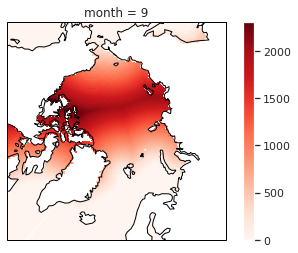

In [33]:
fig,ax = plt.subplots()

ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.coastlines()
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_cice18_6h[20].plot.pcolormesh('TLON','TLAT',ax=ax,transform=ccrs.PlateCarree(),cmap='Reds')

In [ ]:
fig,ax = plt.subplots()

ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.coastlines()
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
dist_cice18_6h[20].plot.pcolormesh('TLON','TLAT',ax=ax,transform=ccrs.PlateCarree(),cmap='Reds')

In [9]:
# dist_cice18_6h.where(dist_cice18_6h>0.15)
ww18_aice15 = ww18.sel(nj=latslice).where(cice18_6h_aice.sel(nj=latslice)>0.15)
dist_cice18_6h_15 = dist_cice18_6h.where(cice18_6h_aice.sel(nj=latslice)>0.15)

Text(0.5, 1.0, '2018 In Situ/Remote Hybrid obs: sigwaveheight vs. distance from ice edge')

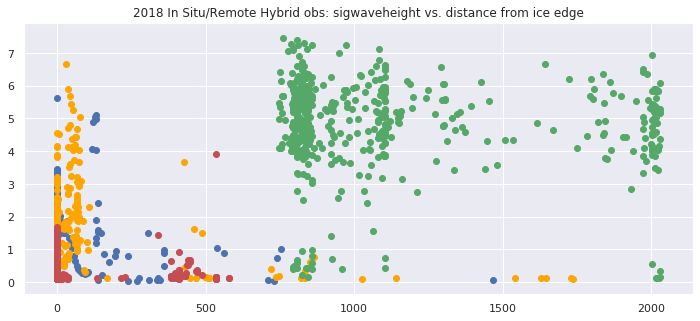

In [48]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(dist_sat18_sodaA.sel(
    nj=347-300,ni=210),sodaA.sigwaveheight,label='SODA A',c='b')
plt.scatter(dist_sat18_sodaB.sel(
    nj=351-300,ni=208),sodaB.sigwaveheight,label='SODA B',c='orange')
plt.scatter(dist_sat18_sodaC.sel(
    nj=356-300,ni=208),sodaC.sigwaveheight,label='SODA C',c='g')
plt.scatter(dist_sat18_BGEP.sel(
    nj=350-300,ni=206),bds18.sigwaveheight,label='BGEP',c='r')
plt.title('2018 In Situ/Remote Hybrid obs: sigwaveheight vs. distance from ice edge')

Text(0.5, 1.0, '2018 Model sigwaveheight vs. distance from ice edge')

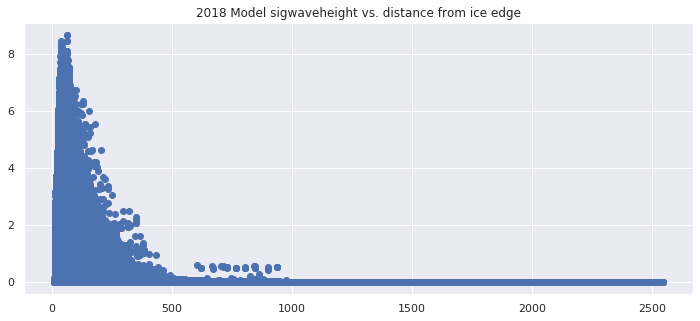

In [45]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(dist_cice18_6h_15,ww18_aice15.hs)
plt.title('2018 Model sigwaveheight vs. distance from ice edge')

Text(0.5, 1, '2018 sigwaveheight vs. distance from ice edge')

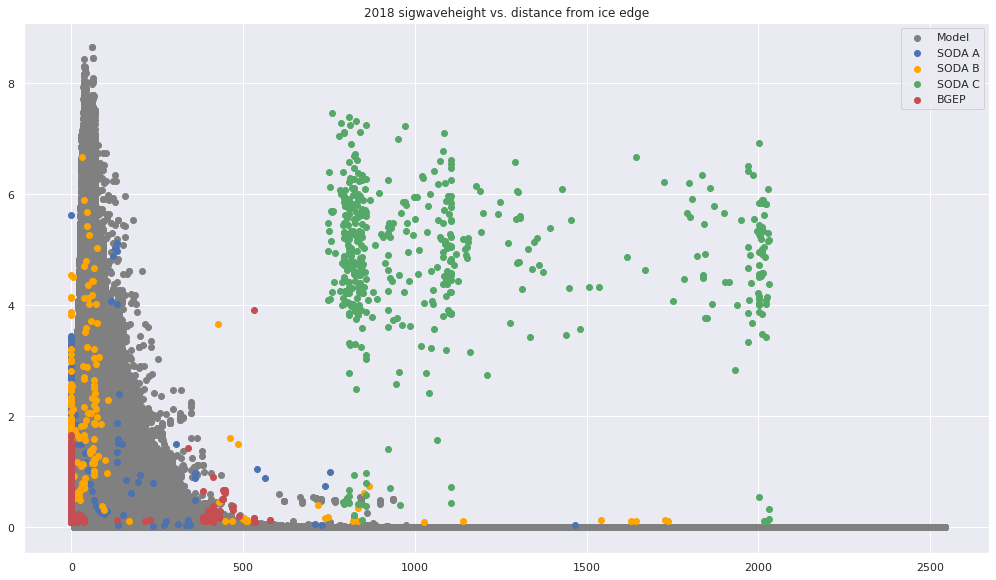

In [10]:
fig = plt.subplots(figsize=(14,8))

plt.scatter(dist_cice18_6h_15,ww18_aice15.hs,label='Model',c='gray')

plt.scatter(dist_sat18_sodaA.sel(
    nj=347-300,ni=210),sodaA.sigwaveheight,label='SODA A',c='b')
plt.scatter(dist_sat18_sodaB.sel(
    nj=351-300,ni=208),sodaB.sigwaveheight,label='SODA B',c='orange')
plt.scatter(dist_sat18_sodaC.sel(
    nj=356-300,ni=208),sodaC.sigwaveheight,label='SODA C',c='g')
plt.scatter(dist_sat18_BGEP.sel(
    nj=350-300,ni=206),bds18.sigwaveheight,label='BGEP',c='r')

plt.legend(); plt.tight_layout()
plt.title('2018 sigwaveheight vs. distance from ice edge')

#### Plot a subset of SODA data that pertains to our timeframe